In [125]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import string
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
import emoji
nltk.download('punkt')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from keras.layers import LSTM, Dense, SimpleRNN, Embedding, Flatten, Dropout
from keras.activations import softmax
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wafts\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wafts\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [126]:
# df = pd.read_csv('/content/final_preprocessed_dataset.csv')
df = pd.read_csv("DATA/TRAINING DATASET/final_preprocessed_dataset_undersampling.csv")

df.head()

,created_at,full_text_processed,label
0,06/04/2025,besides issue genocide drc even years buy one,1.0
1,06/04/2025,anybody needs chip inserted brain named fafo s...,0.0
2,06/04/2025,2ledged support justice dignity peace gaza joi...,0.0
3,06/04/2025,taking position gaza taking position gaza one ...,0.0
4,06/04/2025,0hildren gaza stand proof world looked away do...,0.0


In [127]:
# Drop baris dengan label kosong (NaN)
df = df.dropna(subset=['label']).copy()

# Baru konversi label ke integer
df['label'] = df['label'].astype(int)

# Ambil teks dan label
texts = df['full_text_processed'].values
labels = df['label'].values

df.head


<bound method NDFrame.head of       created_at                                full_text_processed  label
0     06/04/2025      besides issue genocide drc even years buy one      1
1     06/04/2025  anybody needs chip inserted brain named fafo s...      0
2     06/04/2025  2ledged support justice dignity peace gaza joi...      0
3     06/04/2025  taking position gaza taking position gaza one ...      0
4     06/04/2025  0hildren gaza stand proof world looked away do...      0
...          ...                                                ...    ...
1476  01/10/2024  2ray israel yes pray israel stop committing ge...      0
1477  07/10/2023  2rayers people israel utterly horrifying video...      2
1478  01/10/2024                    2raying brothers sisters israel      2
1479  05/04/2025  one believes arab countries turn tap stop sell...      1
1480  17/05/2024   0hristian leaders hold day prayer israel weekend      1

[1471 rows x 3 columns]>

In [128]:
# Tokenisasi
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [143]:
from gensim.models import Word2Vec

embedding_dim = 100

w2v_model = Word2Vec(
    sentences=tokenized_texts,
    vector_size=embedding_dim,
    window=5,
    min_count=2,
    workers=4,
    epochs=50
)


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [129]:
# Padding
maxlen = 45
X_padded = pad_sequences(sequences, maxlen=maxlen, padding='post')

In [130]:
# Split data stratified
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, labels, test_size=0.2, stratify=labels, random_state=42
)

In [139]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=100, input_length=maxlen))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))  # 3 kelas

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.build(input_shape=(None, maxlen))

model.summary()


d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 45, 100)        │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 542,435 (2.07 MB)

 Trainable params: 542,435 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

In [140]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)


Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 0.3462 - loss: 1.0996 - val_accuracy: 0.3322 - val_loss: 1.0991
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.3163 - loss: 1.1012 - val_accuracy: 0.3356 - val_loss: 1.0986
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.3352 - loss: 1.0995 - val_accuracy: 0.3322 - val_loss: 1.0987
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.3117 - loss: 1.0996 - val_accuracy: 0.3322 - val_loss: 1.0986
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.3310 - loss: 1.0984 - val_accuracy: 0.5085 - val_loss: 1.0048
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.5619 - loss: 0.9234 - val_accuracy: 0.4915 - val_loss: 1.0296
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.5700 - loss: 0.9033 - val_accuracy: 0.4746 - val_loss: 1.1383
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.5752 - loss: 0.8589 - val_accuracy:

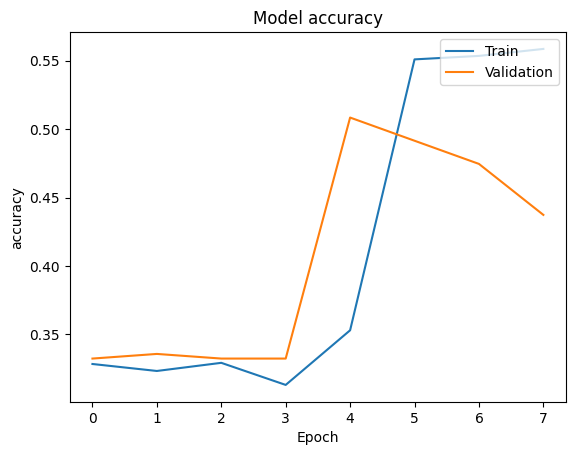

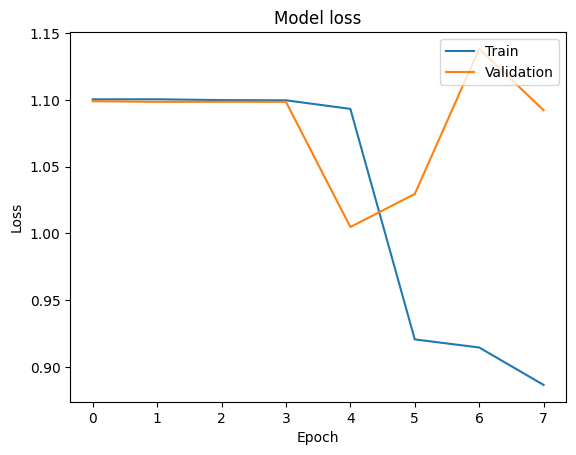

In [141]:
# Plotting the training and testing accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting the training and testing loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step
Akurasi: 0.5084745762711864
              precision    recall  f1-score   support

     Negatif       0.53      0.70      0.60        98
     Positif       0.00      0.00      0.00        99
      Netral       0.49      0.83      0.62        98

    accuracy                           0.51       295
   macro avg       0.34      0.51      0.41       295
weighted avg       0.34      0.51      0.41       295



d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

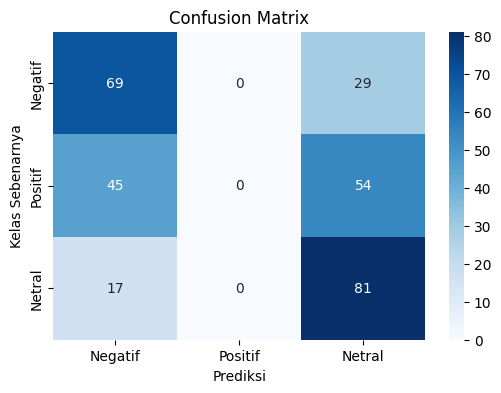

In [142]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("Akurasi:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["Negatif", "Positif", "Netral"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negatif", "Positif", "Netral"],
            yticklabels=["Negatif", "Positif", "Netral"])
plt.xlabel("Prediksi")
plt.ylabel("Kelas Sebenarnya")
plt.title("Confusion Matrix")
plt.show()


Uji Coba Kode Baru


In [93]:
vocab_size = len(tokenizer.word_index) + 1
print("Vocab size:", vocab_size)


Vocab size: 4787


In [94]:
# Define the model
model = Sequential()

model.add(Embedding(input_dim=vocab_size+1, output_dim=100, input_length=45))

# Use LSTM instead of SimpleRNN for better capturing long-term dependencies
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))  

# Output layer with sigmoid activation for binary classification
model.add(Dense(3, activation='softmax')) 

# Compile the model
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

model.build(input_shape=(None, maxlen))
# Print model summary
model.summary()

d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 45, 100)        │       478,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 521,235 (1.99 MB)

 Trainable params: 521,235 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

In [95]:
# Model Train 
history = model.fit(
    X_train_padded, 
    y_train, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_test_padded, y_test)
    )

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - accuracy: 0.3310 - loss: 1.0997 - val_accuracy: 0.3661 - val_loss: 1.0962
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.3388 - loss: 1.0993 - val_accuracy: 0.2983 - val_loss: 1.1128
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.3611 - loss: 1.1001 - val_accuracy: 0.3356 - val_loss: 1.0973
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.3704 - loss: 1.0984 - val_accuracy: 0.2983 - val_loss: 1.0982
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.4815 - loss: 1.0236 - val_accuracy: 0.5085 - val_loss: 1.0137
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.6035 - loss: 0.8249 - val_accuracy: 0.4169 - val_loss: 1.1329
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6076 - loss: 0.7791 - val_accuracy: 0.4169 - val_loss: 1.1404
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5832 - loss: 0.7883 - val_accuracy: 0.3898 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Akurasi: 38.31%

Classification Report:
              precision    recall  f1-score   support

     Negatif       0.65      0.30      0.41        99
      Netral       0.00      0.00      0.00       108
     Positif       0.33      0.94      0.49        88

    accuracy                           0.38       295
   macro avg       0.33      0.42      0.30       295
weighted avg       0.32      0.38      0.29       295



d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\1 KULIAH\TUGAS AKHIR\Skripsi\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

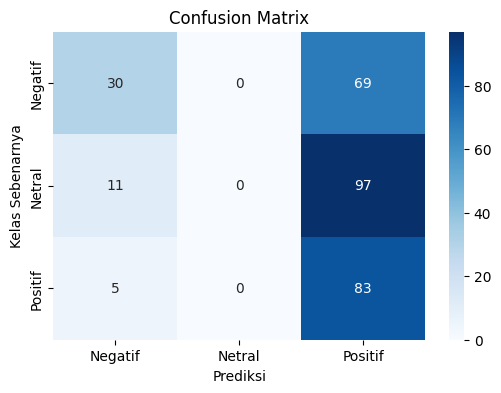

In [99]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ==== STEP 1: Lakukan Prediksi ====
# Kalau target kamu berupa angka: 0, 1, 2
y_pred_probs = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)  # ambil label prediksi (kelas tertinggi)

# ==== STEP 2: Hitung dan Cetak Akurasi ====
acc = accuracy_score(y_test, y_pred)
print(f"Akurasi: {acc * 100:.2f}%")

# ==== STEP 3: Classification Report ====
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Negatif", "Netral", "Positif"]))

# ==== STEP 4: Confusion Matrix ====
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negatif", "Netral", "Positif"],
            yticklabels=["Negatif", "Netral", "Positif"])
plt.xlabel('Prediksi')
plt.ylabel('Kelas Sebenarnya')
plt.title('Confusion Matrix')
plt.show()


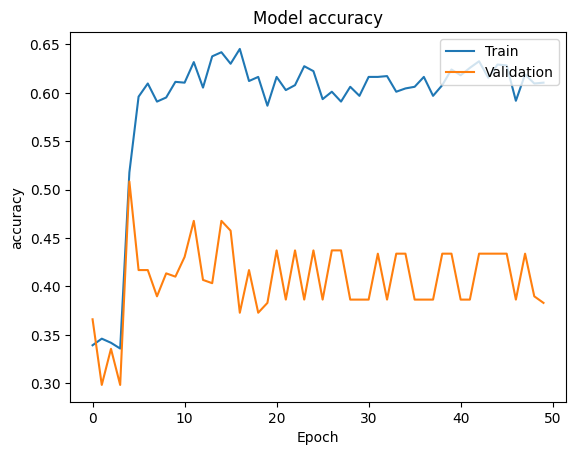

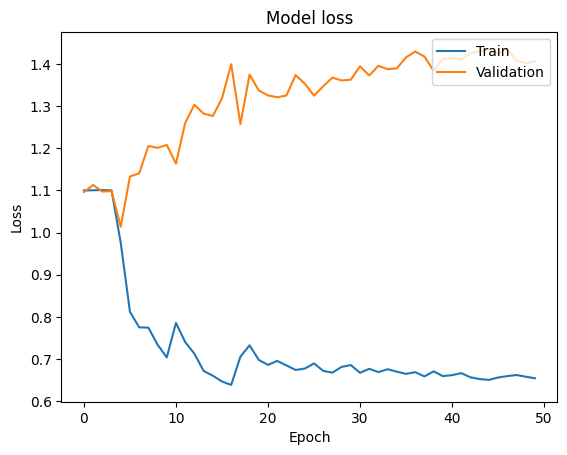

In [97]:
# Plotting the training and testing accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting the training and testing loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [98]:
df['label'].value_counts()


label
1    492
0    490
2    489
Name: count, dtype: int64